In [1]:
import gym
import numpy as np
import tensorflow as tf
from collections import deque
import random
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import time
from environment import Vasuki
from tqdm import tqdm

reward_list = [0]
batch_size = 128
num_of_episodes = 500
show_preview = 2000
config = {'n': 8, 'rewards': {'Food': 4, 'Movement': -1, 'Illegal': -2},
                  'game_length': 100}  # Should not change for evaluation
env = Vasuki(**config)
# env=wrap_deepmind(env)
done = False
env.reset()
update_weights_counter = 5
Metric_Titles = ['ScoreA', 'ScoreB']


class Agent:

    def __init__(self, enviroment):

        self.action_size = 3
        self.ob_size = 16  # enviroment.observation_space
        self.deque_maxlen = 1_000_000
        self.expirience_replay = deque(maxlen=self.deque_maxlen)
        self.epsilon = 1
        self.epsilon_min = 0.1
        self.discount = 0.99
        self.max_timesteps = 100
        self.loss = 0
        self.loss_list = []

        # self.total_frames = 100 #10_000_000
        self.max_episodes = 50
        #self.learn_every_n_frame = 1
        self.explore_episodes = 25
        #self.update_target_every = 1
        # self.min_epsilon_episode = 1149#2000
        # (self.epsilon - self.epsilon_min) / (self.min_epsilon_episode-self.explore_episodes)
        self.epsilon_decrement = 0.996

        self.q_model = self.atari_model()
        #self.target_q_model = self.atari_model()
        # self.align_target_model()

    def act(self, state, episode_no):
        if episode_no < self.explore_episodes:
            return int(np.random.choice(3))

        elif np.random.rand() <= self.epsilon:
            return int(np.random.choice(3))
        else:
            q_values = self.q_model.predict(state)
            return np.argmax(q_values[0])

    def store(self, state, action, reward, next_state, terminated):
        if len(self.expirience_replay) == self.deque_maxlen:
            self.expirience_replay.popleft()
            self.expirience_replay.append(
                (state, action, reward, next_state, terminated))
        else:
            self.expirience_replay.append(
                (state, action, reward, next_state, terminated))

    # def align_target_model(self):
        # self.target_q_model.set_weights(self.q_model.get_weights())

    def retrain(self, batch_size):

        minibatch = random.sample(self.expirience_replay, batch_size)
        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.q_model.predict(current_states.squeeze())
        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array(
            [transition[3] for transition in minibatch])
        future_qs_list = self.q_model.predict(new_current_states.squeeze())

        x = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, terminated) in enumerate(minibatch):
            #reward = self.transform_reward(reward)
            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if terminated:
                continue
            max_future_q = np.max(future_qs_list[index])
            # Update Q value for given state
            current_qs = current_qs_list[index]

            current_qs[action] = reward + agent.discount * max_future_q
            # And append to our training data
            x.append(current_state.squeeze())
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        history = self.q_model.fit(np.array(x), np.array(
            y), batch_size=batch_size, epochs=1, verbose=0)
        self.loss += history.history['mse'][0]

    def atari_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(150, activation='relu',
                                  input_shape=(self.ob_size,)),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        optimizer = tf.keras.optimizers.Adam(0.0005)
        model.compile(optimizer, loss='mse', metrics=['mse'])
        return model

    def preprocessA(self, info):
        obs = info['agentA']['state']
        obs = np.append(obs, info['agentA']['head'])
        obs = np.append(obs, info['agentA']['score'])
        obs = np.append(obs, info['agentB']['state'])
        obs = np.append(obs, info['agentB']['head'])
        obs = np.append(obs, info['agentB']['score'])
        obs = np.append(obs, env.live_foodspawn_space.astype(np.int))
        obs = obs.reshape(1, -1)
        return obs

    def preprocessB(self, info):
        obs = info['agentB']['state']
        obs = np.append(obs, info['agentB']['head'])
        obs = np.append(obs, info['agentB']['score'])
        obs = np.append(obs, info['agentA']['state'])
        obs = np.append(obs, info['agentA']['head'])
        obs = np.append(obs, info['agentA']['score'])
        obs = np.append(obs, env.live_foodspawn_space.astype(np.int))
        obs = obs.reshape(1, -1)
        return obs


In [4]:
agent = Agent(env)

frame = 0
ep_reward = 0
realign = 1
exit = False
results = {key: [] for key in Metric_Titles}
for ep in tqdm(range(1, agent.max_episodes+1)):
    if exit == True:
        break
    begin = time.time()
    env.reset()
    action = {'actionA': 0, 'actionB': 0}
    rewardA, rewardB, done, info = env.step(action)
    done = False
    Metric_Buffer = {key: [] for key in Metric_Titles}

    while not done:
        observationsA = agent.preprocessA(info)
        observationsB = agent.preprocessB(info)

        actionA = agent.act(observationsA, ep)
        actionB = agent.act(observationsB, ep)
        action = {'actionA': actionA, 'actionB': actionB}

        # Caching the information of current state
        prev_observationsA = observationsA
        prev_observationsB = observationsB
        modifiedA, _ = env._movement_(actionA, info['agentA'])
        modifiedB, _ = env._movement_(actionB, info['agentB'])
        info['agentA'] = modifiedA
        info['agentB'] = modifiedB
        observationsA = agent.preprocessA(info)
        observationsB = agent.preprocessB(info)
        # Take action
        rewardA, rewardB, done, info = env.step(action)
        agent.store(prev_observationsA, actionA,
                    rewardA, observationsA, done)
        agent.store(prev_observationsB, actionA,
                    rewardA, observationsA, done)
        Metric_Buffer['ScoreA'].append(rewardA)
        Metric_Buffer['ScoreB'].append(rewardB)
        # Adding experience into buffer
        if ep > agent.explore_episodes:
            agent.retrain(batch_size)
            # if realign % agent.update_target_every == 0:
            # agent.align_target_model()
            #realign +=1
            agent.epsilon = (
                agent.epsilon * agent.epsilon_decrement) if agent.epsilon > agent.epsilon_min else agent.epsilon_min
    for metric_name in Metric_Titles:
        results[metric_name].append(np.mean(Metric_Buffer[metric_name]))


100%|██████████| 50/50 [08:08<00:00,  9.77s/it]


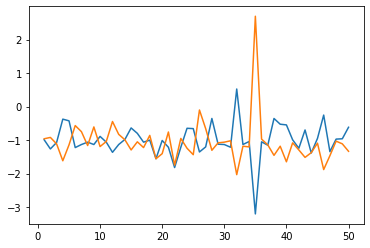

In [5]:
agent.q_model.save("model.h5")

epochs = range(1, agent.max_episodes+1)
plt.plot(epochs,
         results['ScoreA'], label="A")
plt.plot(epochs,
         results['ScoreB'], label="B")